# Inferencing MNIST ONNX Model using AI-Serving

The MNIST handwritten digit classification problem is a classic dataset used in computer vision and deep learning, and Convolutional Neural Network (CNN) is the current state-of-art architecture for image classification task.

In this tutorial, we will use the Open Neural Network eXchange (ONNX) format to show how to deploy a pre-trained MNIST CNN model using AI-Serving.

# <a id="contents"></a>Contents
This notebook contains the following parts:

**[Setup](#setup)**<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Prerequisites to run the notebook](#prerequisites)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Additional information about `ai_serving_pb2.py`](#additional)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Install dependencies](#dependencies)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Import dependent modules](#import)<br />
**[Validate server](#validate)**<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Define the base HTTP URL](#httpurl)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Test the server availability](#testserver)<br />
**[Deploy the ONNX model](#deploy)**<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Deploy the MNIST model into AI-Serving](#deploy-onnx)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Retrieve metadata of the deployed model](#metadata)<br />
**[Make predictions](#predictions)**<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Load the testing images](#test-data)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[HTTP request formats](#request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[Binary requests](#binary-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Construct binary requests](#construct-binary-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Make the HTTP requests with binary data](#make-binary-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Consume the HTTP responses with binary data](#consume-binary-response)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Parse the response message from the `records` request](#parse-binary-response-records)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Parse the response message from the `split` request](#parse-binary-response-split)<br />
&nbsp;&nbsp;&nbsp;&nbsp;[JSON requests](#json-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Construct JSON requests](#construct-json-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Make the HTTP requests with JSON data](#make-json-request)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Consume the HTTP response with JSON data](#consume-json-response)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Parse the json response message from the `records` request](#parse-json-response-records)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[Parse the json response message from the `split` request](#parse-json-response-split)<br />
**[Next steps](#next-steps)**<br />

# <a id="setup"></a>Setup

## <a id="prerequisites"></a>Prerequisites to run the notebook

Run a docker container of AI-Serving. The port `9090` is the port of HTTP endpoint while `9091` is for gRPC, you could see an error likes `Bind for 0.0.0.0:9090 failed: port is already allocated`, then use another new port instead of the first part as follows `-p $(NEW_PORT):9090` to run the command again, and remember the port is always needed in the URL of HTTP endpoint. It will aslo pull the latest docker image of AI-Serving with ONNX that leverages the CPU version of [ONNX Runtime](https://github.com/microsoft/onnxruntime) from [docker hub](https://hub.docker.com/r/autodeployai/ai-serving) if it hvaen't been downloaded yet. Please, refer to [Docker Containers for AI-Serving](https://github.com/autodeployai/ai-serving/tree/master/dockerfiles) about more docker images.

```bash
docker run --rm -it -v $(PWD):/opt/ai-serving -p 9090:9090 -p 9091:9091 autodeployai/ai-serving
```

## <a id="additional"></a>Additional information about `ai_serving_pb2.py`
In the current directory, there is a python file `ai_serving_pb2.py`, which is generated from compiling the [ai-serving.proto](https://github.com/autodeployai/ai-serving/tree/master/src/main/protobuf/ai-serving.proto) using [protoc](https://developers.google.com/protocol-buffers/docs/pythontutorial), for example, the command as follows:

```bash
protoc -I=$SRC_DIR --python_out=. ai-serving.proto
```

## <a id="dependencies"></a>Install dependencies
We will install python libraries for HTTP request, data manipulation, image manipulation and display:

In [ ]:
!pip install requests
!pip install numpy
!pip install onnx
!pip install pillow
!pip install matplotlib

## <a id="import"></a>Import dependent modules
Import some dependent modules that we are going to need to run the MNIST ONNX model.

In [10]:
import os
import numpy as np
import requests
from matplotlib import pyplot as plt
from PIL import Image
from pprint import pprint

import onnx
import ai_serving_pb2

# <a id="validate"></a>Validate server

## <a id="httpurl"></a>Define the base HTTP URL
Change the port number `9090` to the appropriate port number if you had changed it during AI-Serving docker instantiation

In [13]:
port = 9090
base_url = 'http://localhost:' + str(port)

## <a id="testserver"><a>Test the server availability
Use the specific endpoint `http://host:port/up` to test whether the server has been initialized and is ready to accept requests. The `OK` message indicates it's already available.

In [15]:
test_url = base_url + '/up'
response = requests.get(test_url)
print('The status of the server: ', response.text)

The status of the server:  OK


# <a id="deploy"></a>Deploy the ONNX model

## <a id="deploy-onnx"></a>Deploy the MNIST model into AI-Serving
First, we need to deploy the MNIST ONNX model `models/mnist-8.onnx` that is from [here](https://github.com/onnx/models/raw/refs/heads/main/validated/vision/classification/mnist/model/mnist-8.onnx) into AI-Serving, which can serve multiple models or multiple versions for a named model at once.

You must specify a correct content type for ONNX models when constructing an HTTP request to deploy an ONNX model, the candidates are:
 * application/octet-stream
 * application/vnd.google.protobuf
 * application/x-protobuf

In [18]:
# The specified servable name
model_name = 'mnist'
deployment_url = base_url + '/v1/models/' + model_name

# The specified content type for the model:
headers = {'Content-Type': 'application/x-protobuf'}

model_path = os.path.join('models', 'mnist-8.onnx')
with open(model_path, 'rb') as file:
    deployment_response = requests.put(deployment_url, headers=headers, data=file)

# The response is a JSON object contains the sepcified servable name and the model version deployed
deployment_response_info = deployment_response.json()
print('The depoyment response: ', deployment_response_info)

The depoyment response:  {'name': 'mnist', 'version': 1}


## <a id="metadata"></a>Retrieve metadata of the deployed model
The metadata will contain model inputs and outputs, which are needed when constructing an input request and consume an output response.

In [20]:
model_version = deployment_response_info['version']
metadata_url = base_url + '/v1/models/' + model_name + '/versions/' + str(model_version)
metadata_response = requests.get(metadata_url)
metadata_response_json = metadata_response.json()

# Model info of the specified version
model_info = metadata_response_json['versions'][0]

# Extra some key values: the input tensor name and shape
version_metadata_input = model_info['inputs'][0]
input_shape = version_metadata_input['shape']
input_tensor_name = version_metadata_input['name']

# Extra some key values: the output tensor name and shape
version_metadata_output = model_info['outputs'][0]
output_shape = version_metadata_output['shape']
output_tensor_name = version_metadata_output['name']

# Show the metadata result in json
print('The model metadata info:')
pprint(metadata_response_json)

The model metadata info:
{'createdAt': '2024-10-09T21:25:27',
 'id': '756bd65a-8805-4ea9-a087-1494f8a9c24e',
 'latestVersion': 1,
 'name': 'mnist',
 'updateAt': '2024-10-09T21:25:27',
 'versions': [{'createdAt': '2024-10-09T21:25:27',
               'hash': 'd7cd24a0a76cd492f31065301d468c3d',
               'inputs': [{'name': 'Input3',
                           'shape': [1, 1, 28, 28],
                           'type': 'tensor(float)'}],
               'outputs': [{'name': 'Plus214_Output_0',
                            'shape': [1, 10],
                            'type': 'tensor(float)'}],
               'runtime': 'ONNX Runtime',
               'serialization': 'onnx',
               'size': 26454,
               'type': 'ONNX',
               'version': 1}]}


# <a id="predictions"></a>Make predictions

## <a id="test-data"></a>Load the testing images
We will use those test images in the directory `images`

The testing image list:


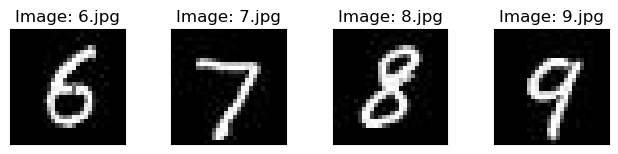

In [23]:
input_tensors = []
input_arrays = []

image_size = input_shape[-2:]
def preprocess_image_toarray(img):
    """Resize input images and convert them to grayscale."""
    gray_img = img.convert('L')
    processed_img = gray_img.resize(image_size)
    return np.asarray(processed_img)

def postprocess(predictions):
    """postprocess the raw predictions"""
    return int(np.argmax(np.array(predictions).squeeze(), axis=0))

# Collect the testing images
images_dir = 'images'
name_list = []
for filename in os.listdir(images_dir):
    if filename.split(".")[-1] in ('png', 'jpg'):
        name_list.append(filename)
name_list.sort()

# Read the testing images, and preprocess them into the desired size.
images = []
for filename in name_list:
    filepath = os.path.join(images_dir, filename)
    img = Image.open(filepath)
    img_array = preprocess_image_toarray(img)
    images.append((filename, img_array))

# Create the input tensor from the testing image.
i = 0
for x in images:
    filename = x[0]
    img_processed = x[1]

    # Create onnx.TensorProto. In general, there are two ways
    # 1. Save the data by the specified data type
    # 2. Save the data by the raw way that contains the serialized content of the tensor.
    onnx_tensor = onnx.helper.make_tensor(name='', 
                                          data_type=onnx.TensorProto.FLOAT, 
                                          dims=input_shape,
                                          vals=img_processed.astype(np.float32))

    # Convert to ai_serving_pb2.TensorProto from onnx.TensorProto
    # Both messages are compatiable with each other
    input_tensor = ai_serving_pb2.TensorProto()
    input_tensor.ParseFromString(onnx_tensor.SerializeToString())
    input_tensors.append(input_tensor)
    input_arrays.append(img_processed)        
    
    # Add a subplot for the current digit.
    plt.subplot(1, len(images), i+1)
    plt.tight_layout()
    plt.imshow(img_processed.reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title('Image: {}'.format(filename))
    plt.xticks([])
    plt.yticks([])
    
    i += 1
print('The testing image list:')
plt.show()

## <a id="request"></a>HTTP request formats
The request for AI-Serving could have two formats: JSON and binary, the HTTP header Content-Type tells the server which format to handle and thus it is required for all requests. The binary payload has better latency, especially for the big tensor value for ONNX models, while the JSON format is easy for human readability.

- Content-Type: application/octet-stream, application/vnd.google.protobuf or application/x-protobuf. The request body must be the protobuf message PredictRequest, besides of those common scalar values, it can use the standard onnx.TensorProto value directly.


- Content-Type: application/json. The request body must be a JSON object formatted as described [here](https://github.com/autodeployai/ai-serving#4-predict-api).

## <a id="binary-request"></a>Binary requests

### <a id="construct-binary-request"></a>Construct binary requests
We will create both instances of PredictRequest, one is using the `Records` format that has the first 2 cases, the other is using the `Split` format that contains others.

In [27]:
from ai_serving_pb2 import RecordSpec, Record, PredictRequest, ListValue, Value

# Create an instance of RecordSpec using `records` that contains the first 2 tensors.
request_message_records = PredictRequest(X=RecordSpec(
    records=[ Record(fields={input_tensor_name: Value(tensor_value=x)}) for x in input_tensors[0:2] ]
))

# Create an instance of RecordSpec using `split` that contains the left tensors.
request_message_split = PredictRequest(X=RecordSpec(
    columns = [input_tensor_name],
    data = [ ListValue(values=[Value(tensor_value=x)]) for x in input_tensors[2:] ]
))

### <a id="make-binary-request"></a>Make the HTTP requests with binary data
Make predictions using the AI-Serving, the content type of requests with binary data must be one of those three candidates above.

In [29]:
headers = {'Content-Type': 'application/x-protobuf'}

# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# Make prediction for the `records` request message.
prediction_response_records = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_records.SerializeToString())

# Make prediciton for the `split` request message.
prediction_response_split = requests.post(prediction_url, 
                                           headers=headers, 
                                           data=request_message_split.SerializeToString())

### <a id="consume-binary-response"></a>Consume the HTTP responses with binary data
Having received the results from the server, we are going to parse the "serialized" message that we just received for us to make sense of the results. And compare the actual results to the desired ones. **NOTE: The data format of the output response is always the same as the input request.**

#### <a id="parse-binary-response-records"></a>Parse the response message from the `records` request

Raw predictions of "6.jpg": [  714.41437 -2176.6016  -1575.0326   -880.8216  -1648.9232   2636.4424
  4059.8008  -3973.2715   1262.9858  -1492.2789 ]
Final recognized digit: 6
------------------------------------------------------------------------------------------------------------------------
Raw predictions of "6.jpg": [ -514.49316   138.14052  2192.4036   2244.1516  -3340.5215  -1775.897
 -6222.5186   7784.408   -1814.3502    934.81805]
Final recognized digit: 7
------------------------------------------------------------------------------------------------------------------------


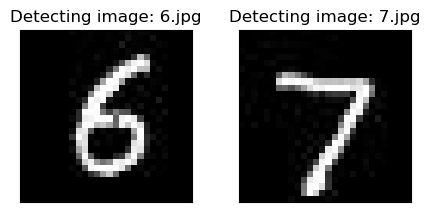

In [32]:
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_records.content)

i = 0
for x in response_message.result.records:
    output_tensor_value = x.fields[output_tensor_name].tensor_value
    output_tensor_array = np.asarray(output_tensor_value.float_data, dtype=np.dtype('float32'))
    
    # Print the prediction for the testing image
    print('Raw predictions of "{}": {}'.format(images[0][0], output_tensor_array))
    print('Final recognized digit: {}'.format(postprocess(output_tensor_array)))
    print('-'*120)
    
    # Add a subplot for the current digit.
    plt.subplot(1, len(images) - 1, i + 1)
    plt.tight_layout()
    plt.imshow(images[i][1].reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title('Detecting image: {}'.format(images[i][0]))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

#### <a id="parse-binary-response-split"></a>Parse the response message from the `split` request

Raw predictions of "8.jpg": [  397.46228 -2270.2764   1143.2241    850.3334   -468.74387  -592.69666
   327.9959  -4857.1685   4933.365    -390.23157]
Final recognized digit: 8
------------------------------------------------------------------------------------------------------------------------
Raw predictions of "9.jpg": [-2689.0283  -3374.9338  -1715.207    -871.94696  3004.0815   -926.28235
 -3160.6943   1612.2079    463.7397   5574.235  ]
Final recognized digit: 9
------------------------------------------------------------------------------------------------------------------------


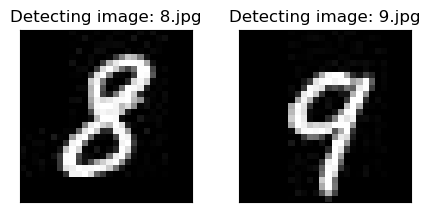

In [34]:
response_message = ai_serving_pb2.PredictResponse()
response_message.ParseFromString(prediction_response_split.content)

i = 2
for x in response_message.result.data:
    output_tensor_value = x.values[0].tensor_value
    output_tensor_array = np.asarray(output_tensor_value.float_data, dtype=np.dtype('float32'))

    # Print the prediction for the testing image
    print('Raw predictions of "{}": {}'.format(images[i][0], output_tensor_array))
    print('Final recognized digit: {}'.format(postprocess(output_tensor_array)))
    print('-'*120)

    # Add a subplot for the current digit.
    plt.subplot(1, len(images) - 1, i - 1)
    plt.tight_layout()
    plt.imshow(images[i][1].reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title('Detecting image: {}'.format(images[i][0]))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

## <a id="json-request"></a>JSON requests

### <a id="construct-json-request"></a>Construct JSON requests
Create both JSON objects, one is using the `Records` format that has one case, the other is using `Split` that contains other cases.

In [37]:
# Create a JSON object with records that contains only the first tensor.
request_json_recoreds = {
    'X': [ {input_tensor_name: x.tolist()} for x in input_arrays[0:2]]
}

# Create a JSON object with columns and data that contains the last two tensors.
request_json_split = {
    'X': {
        'columns': [input_tensor_name],
        'data': [ [x.tolist()] for x in input_arrays[2:] ]
    }
}

### <a id="make-json-request"></a>Make the HTTP requests with JSON data
Make predictions using the AI-Serving, the content type of requests with JSON data must be `application/json`.

In [39]:
# When version is omitted, the latest version is used.
prediction_url = base_url + '/v1/models/' + model_name

# The Content-Type: application/json is specified implicitly when using json instead of data
prediction_json_response_records = requests.post(prediction_url, json=request_json_recoreds)
prediction_json_response_split = requests.post(prediction_url, json=request_json_split)

### <a id="consume-json-response"></a>Consume the HTTP response with JSON data
Having received the results from the server, we are going to parse the JSON text that we just received for us to make sense of the results. And compare the actual results to the desired ones. **NOTE: The data format of the output response is always the same as the input request.**

#### <a id="parse-json-response-records"></a>Parse the json response message from the `records` request

Raw predictions of "6.jpg": [[  714.41437 -2176.6016  -1575.0326   -880.8216  -1648.9232   2636.4424
   4059.8008  -3973.2715   1262.9858  -1492.2789 ]]
Final recognized digit: 6
------------------------------------------------------------------------------------------------------------------------
Raw predictions of "6.jpg": [[ -514.49316   138.14052  2192.4036   2244.1516  -3340.5215  -1775.897
  -6222.5186   7784.408   -1814.3502    934.81805]]
Final recognized digit: 7
------------------------------------------------------------------------------------------------------------------------


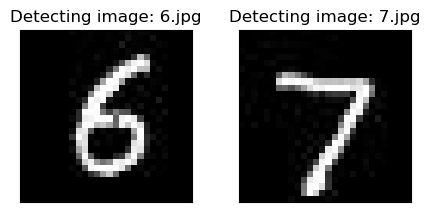

In [42]:
response_json = prediction_json_response_records.json()

i = 0
for x in response_json['result']:
    output_list = x[output_tensor_name]
    output_tensor_array = np.asarray(output_list, dtype=np.dtype('float32'))
    
    # Print the result for the firest testing image
    print('Raw predictions of "{}": {}'.format(images[0][0], output_tensor_array))
    print('Final recognized digit: {}'.format(postprocess(output_tensor_array)))
    print('-'*120)
    
    # Add a subplot for the current digit.
    plt.subplot(1, len(images) - 1, i + 1)
    plt.tight_layout()
    plt.imshow(images[i][1].reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title('Detecting image: {}'.format(images[i][0]))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

#### <a id="parse-json-response-split"></a>Parse the json response message from the `split` request

Raw predictions of "8.jpg": [[[  397.46228 -2270.2764   1143.2241    850.3334   -468.74387
    -592.69666   327.9959  -4857.1685   4933.365    -390.23157]]]
Final recognized digit: 8
------------------------------------------------------------------------------------------------------------------------
Raw predictions of "9.jpg": [[[-2689.0283  -3374.9338  -1715.207    -871.94696  3004.0815
    -926.28235 -3160.6943   1612.2079    463.7397   5574.235  ]]]
Final recognized digit: 9
------------------------------------------------------------------------------------------------------------------------


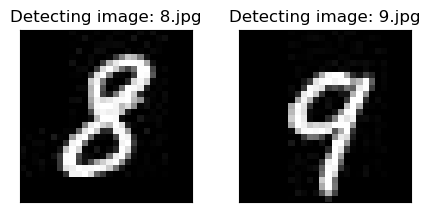

In [44]:
response_json = prediction_json_response_split.json()

i = 2
for x in response_json['result']['data']:
    output_list = x
    output_tensor_array = np.asarray(output_list, dtype=np.dtype('float32'))

    # Print the prediction for the testing image
    print('Raw predictions of "{}": {}'.format(images[i][0], output_tensor_array))
    print('Final recognized digit: {}'.format(postprocess(output_tensor_array)))
    print('-'*120)

    # Add a subplot for the current digit.
    plt.subplot(1, len(images) - 1, i - 1)
    plt.tight_layout()
    plt.imshow(images[i][1].reshape([28, 28]), cmap='gray', interpolation='none')
    plt.title('Detecting image: {}'.format(images[i][0]))
    plt.xticks([])
    plt.yticks([])
    i += 1
plt.show()

## <a id="next-steps"></a>Next steps

I hope the tutoiral can help you to learn how to use the AI-Serving. If you have any questions, please open issues on this repository. Feedback and contributions to the project, no matter what kind, are always very welcome.

**Star the [AI-Serving](https://github.com/autodeployai/ai-serving) project if it's helpful for you!!!**